# Librerías

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
import matplotlib.ticker as ticker
from matplotlib import style
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

%pip install skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Algoritmo genético
# ==============================================================================
%pip install pygad
import pygad as pg

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

# Google Drive
# ==============================================================================
#from google.colab import drive
#drive.mount('/content/drive')

# Datasets

## Generación de energía solar en España

---
Código: SOL

Frecuencia temporal: 1 Hora

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://www.dropbox.com/s/axfbmqdcpquqqun/dataset_solar_1h.csv?dl=1'
datos = pd.read_csv(url, sep=',', names=['fecha', 'y'], usecols=['fecha', 'y'], header=None)

In [ ]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d %H:%M:%S')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('H')
datos = datos.sort_index()
datos.head()

,y
fecha,
2014-01-01 00:00:00,24.000000
2014-01-01 01:00:00,24.000000
2014-01-01 02:00:00,23.833333
2014-01-01 03:00:00,24.000000
2014-01-01 04:00:00,23.166667


In [ ]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [ ]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='60min', fill_value=np.nan)

# Generación de energía eólica en España


---

Código: EOLO

Frecuencia temporal: 10 mins

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://www.dropbox.com/s/2o68sl7q6dcv156/data_no_timestamp.csv?dl=1'
datos = pd.read_csv(url, sep=',', names=['fecha', 'y'], usecols=['fecha', 'y'], header=None)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%dT%H:%M:%S.%f', errors = 'coerce')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('10min')
datos = datos.sort_index()
datos = datos.astype({'y': 'float'})
datos.head()

In [ ]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

In [ ]:
# Completar huecos en un índice temporal
# ==============================================================================
# bool_series = datos['y'].isnull()
# datos[bool_series]

# datos.asfreq(freq='10min', fill_value=np.nan)

# Temperatura de San Francisco


---

Código: TSF

Frecuencia temporal: 1 hora

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://www.dropbox.com/s/60vw4wp6770iqbu/dataset_tsf.csv?dl=1'
datos = pd.read_csv(url, sep=',', names=['y'], usecols=['y'], header=None)

In [ ]:
# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.date_range(start='1/11/2012 13:00:00', periods=len(datos), freq='H')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('H')
datos = datos.sort_index()
datos = datos.astype({'y': 'float'})
datos.head()

In [ ]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

In [ ]:
# Completar huecos en un índice temporal
# ==============================================================================
# bool_series = datos['y'].isnull()
# datos[bool_series]

# datos.asfreq(freq='H', fill_value=np.nan)

# Inicialización y estratégia de ventana

In [ ]:
lags = 48
steps = 1

Fechas train : 2014-01-01 00:00:00 --- 2020-12-31 23:40:00  (n=368207)
Fechas test  : 2020-12-31 23:50:00 --- 2020-12-31 23:50:00  (n=1)


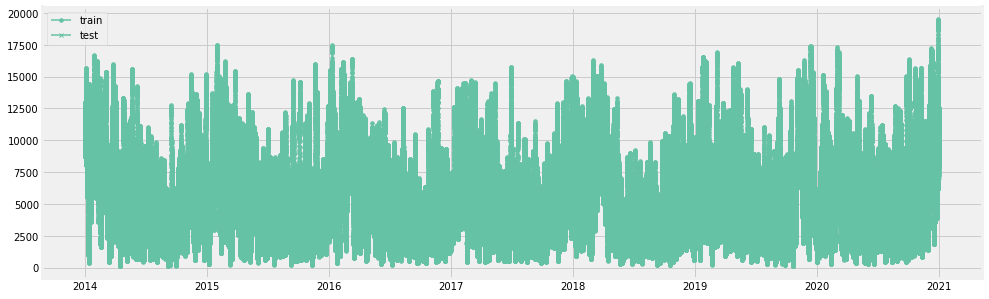

In [ ]:
# Separación datos train-test
# ==============================================================================
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

colors = plt.get_cmap('Set2', 10)

fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(datos_train['y'], 'o-', c=colors(0), markersize=3.5, label='train')
ax.plot(datos_test['y'], 'x-', c=colors(0), markersize=3.5, label='test')
ax.legend();

# Predicción caso base

## ForecasterAutoreg

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = lags
             )

forecaster.fit(datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2020-12-31 23:40:00')] 
Training index type: DatetimeIndex 
Training index frequency: 10T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-12-

In [ ]:
window = forecaster.create_train_X_y(datos_train['y'])
window[0]

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48
fecha,,,,,,,,,,,,,,,,,,,,,
2014-01-01 08:00:00,9708.0,9792.0,9845.0,9850.0,9822.0,9872.0,9902.0,9913.0,9968.0,9981.0,...,11243.0,11179.0,11176.0,10987.0,10978.0,10912.0,11008.0,11079.0,11149.0,11128.0
2014-01-01 08:10:00,9666.0,9708.0,9792.0,9845.0,9850.0,9822.0,9872.0,9902.0,9913.0,9968.0,...,11213.0,11243.0,11179.0,11176.0,10987.0,10978.0,10912.0,11008.0,11079.0,11149.0
2014-01-01 08:20:00,9933.0,9666.0,9708.0,9792.0,9845.0,9850.0,9822.0,9872.0,9902.0,9913.0,...,11102.0,11213.0,11243.0,11179.0,11176.0,10987.0,10978.0,10912.0,11008.0,11079.0
2014-01-01 08:30:00,9904.0,9933.0,9666.0,9708.0,9792.0,9845.0,9850.0,9822.0,9872.0,9902.0,...,11052.0,11102.0,11213.0,11243.0,11179.0,11176.0,10987.0,10978.0,10912.0,11008.0
2014-01-01 08:40:00,9960.0,9904.0,9933.0,9666.0,9708.0,9792.0,9845.0,9850.0,9822.0,9872.0,...,10983.0,11052.0,11102.0,11213.0,11243.0,11179.0,11176.0,10987.0,10978.0,10912.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:00:00,7887.0,8032.0,8044.0,8164.0,8040.0,7877.0,8033.0,8099.0,8043.0,8031.0,...,10096.0,10050.0,10109.0,10129.0,10207.0,10276.0,10350.0,10431.0,10352.0,10480.0
2020-12-31 23:10:00,7771.0,7887.0,8032.0,8044.0,8164.0,8040.0,7877.0,8033.0,8099.0,8043.0,...,9990.0,10096.0,10050.0,10109.0,10129.0,10207.0,10276.0,10350.0,10431.0,10352.0
2020-12-31 23:20:00,7577.0,7771.0,7887.0,8032.0,8044.0,8164.0,8040.0,7877.0,8033.0,8099.0,...,9791.0,9990.0,10096.0,10050.0,10109.0,10129.0,10207.0,10276.0,10350.0,10431.0


In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2020-12-31 23:50:00    7129.78
Freq: 10T, Name: pred, dtype: float64

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

error_mae = mean_absolute_error(datos_test['y'], predicciones)

print(f"Error de test (mse): {error_mse}")
print(f"Error de test (mae): {error_mae}")

Error de test (mse): 450.2884000000108
Error de test (mae): 21.220000000000255


# Ajuste de hiperparámetros

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = lags # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [24]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

# Predicción final

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = lags
             )

forecaster.fit(y=datos_train['y'])

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

2022-02-25    39.097241
Freq: H, Name: pred, dtype: float64

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

error_mae = mean_absolute_error(datos_test['y'], predicciones)

print(f"Error de test (mse): {error_mse}")
print(f"Error de test (mae): {error_mae}")

Error de test (mse): 34.84256749245909
Error de test (mae): 5.902759311750657


# Algoritmo genético

In [ ]:
function_inputs = datos_train['y'][:48]
desired_output = datos_test['y'][0]

In [ ]:
def fitness_func(solution, solution_idx):
    output = np.sum(solution*function_inputs)
    fitness = 1.0 / np.abs(output - desired_output)
    return fitness

In [ ]:
fitness_function = fitness_func

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [ ]:
ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

In [ ]:
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

prediction = np.sum(np.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [-3.12490887  1.56340335  0.99667457 -0.4330145  -0.36318699 -1.745986
 -0.94163263  3.01198829  4.54733298 -1.67807689  3.91066719 -2.54098127
 -1.78645156 -0.08483592 -1.96101106  0.61088098 -2.07683298 -2.95719514
 -0.06125509  0.71621025  1.98014302 -0.44296854  3.30862819  0.99910378
 -2.90023211 -0.67983943  3.37496525  1.46218416 -3.73728743 -1.44351556
 -2.5176048   1.72589926  3.75344506 -2.10173709 -0.28365075  2.29263356
  1.9057329  -0.30222329 -2.62331426 -0.64667414  1.64821854  0.14020174
  0.04952852 -2.40881175  2.95651599 -1.7214395  -0.90338934  2.10833557]
Fitness value of the best solution = 0.008095032574281827
Predicted output based on the best solution : 7027.46745200544


# Bucle de genético

In [ ]:
# Preparativos
# ==============================================================================
from collections import defaultdict
results = defaultdict(lambda: {})

# Descarga de datos
# ==============================================================================
url = 'https://www.dropbox.com/s/2o68sl7q6dcv156/data_no_timestamp.csv?dl=1'
datos = pd.read_csv(url, sep=',', names=['fecha', 'y'], usecols=['fecha', 'y'], header=None)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%dT%H:%M:%S.%f', errors = 'coerce')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('10min')
datos = datos.astype({'y': 'float'})
datos = datos.sort_index()

for i in range(0, len(datos) - 49):
  # Separación datos train-test
  # ==============================================================================
  function_inputs = datos['y'][i:i+48]
  desired_output  = datos['y'][i+48:i+49]

  # Función fitness
  # ==============================================================================
  def fitness_func(solution, solution_idx):
    output = np.sum(solution*function_inputs)
    fitness = 1.0 / np.abs(output - desired_output)
    return fitness[0]

  # Crear y entrenar
  # ==============================================================================
  fitness_function = fitness_func

  num_generations = 50
  num_parents_mating = 4

  sol_per_pop = 8
  num_genes = len(function_inputs)

  init_range_low = -2
  init_range_high = 5

  parent_selection_type = "sss"
  keep_parents = 1

  crossover_type = "single_point"

  mutation_type = "random"
  mutation_percent_genes = 10

  ga_instance = pg.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

  # Predicciones
  # ==============================================================================
  ga_instance.run()

  solution, solution_fitness, solution_idx = ga_instance.best_solution()
  #print("Parameters of the best solution : {solution}".format(solution=solution))
  #print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

  prediction = np.sum(np.array(function_inputs)*solution)
  #print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

  # Error test
  # ==============================================================================
  error_mse = mean_squared_error(
                  y_true = desired_output,
                  y_pred = [prediction]
              )

  error_mae = mean_absolute_error(desired_output, [prediction])

  results['Iter'][i] = i
  results['Solut'][i] = solution
  results['Orig'][i] = desired_output[0]
  results['Pred'][i] = prediction
  results['MAE'][i] = error_mae

  #print("Iteración: ", i,", Original: ", desired_output[0],", MAE: ", error_mae)
  #print("- - - - - - - - - - - - - - - - - -")

# Registro en CSV

In [ ]:
import csv

with open('/content/drive/MyDrive/Ejecucion1EOLO.csv', 'w') as csvfile:
  fieldnames = ['iter', 'solut', 'orig', 'pred', 'mae']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

  writer.writeheader()
  for i in range(len(results['MAE'])):
    writer.writerow({'iter': results['Iter'][i],
                     'solut': results['Solut'][i],
                     'orig': results['Orig'][i],
                     'pred': results['Pred'][i],
                     'mae': results['MAE'][i]})

# Lectura de CSV

In [ ]:
from collections import defaultdict
results = defaultdict(lambda: {})

# Read training set
filename = '/content/drive/MyDrive/Investigación/CSVs PyGAD/Ejecucion3.csv'
datos = pd.read_csv(filename, sep=',')
datos = datos.set_index('iter')

for i in range(len(datos)):
  results['Iter'][i] = i
  results['Solut'][i] = datos['solut'][i].split()
  results['Orig'][i] = datos['orig'][i]
  results['Pred'][i] = datos['pred'][i]
  results['MAE'][i] = datos['mae'][i]

# Operaciones

In [ ]:
sum(results['MAE'].values()) / len(results['MAE'])

In [ ]:
max(results['MAE'].values())

In [ ]:
min(results['MAE'].values())

# Mapa de Calor

In [ ]:
import seaborn as sns

def heatmap_generations(solutions):
  heat2 = []

  errors = []
  for x in solutions:
    for z in x:
      if (z != '[' and z != ']'):
        w = z.replace("[", "")
        h = w.replace("]", "")
        errors.append(float(h))

  index_pos = np.arange(0, len(solutions))
  index_alfa = np.arange(0, len(solutions))

  data = {
      'generacion': np.repeat(index_pos, len(solutions)),
      'posicion': np.tile(index_alfa, len(solutions)),
      'ventana': errors
    }

  df = pd.DataFrame(data, columns = ['generacion', 'posicion', 'ventana'])
  df = df.pivot('generacion', 'posicion', 'ventana')

  fig, ax = plt.subplots(figsize=(50,50)) 

  sns.heatmap(df, ax=ax)

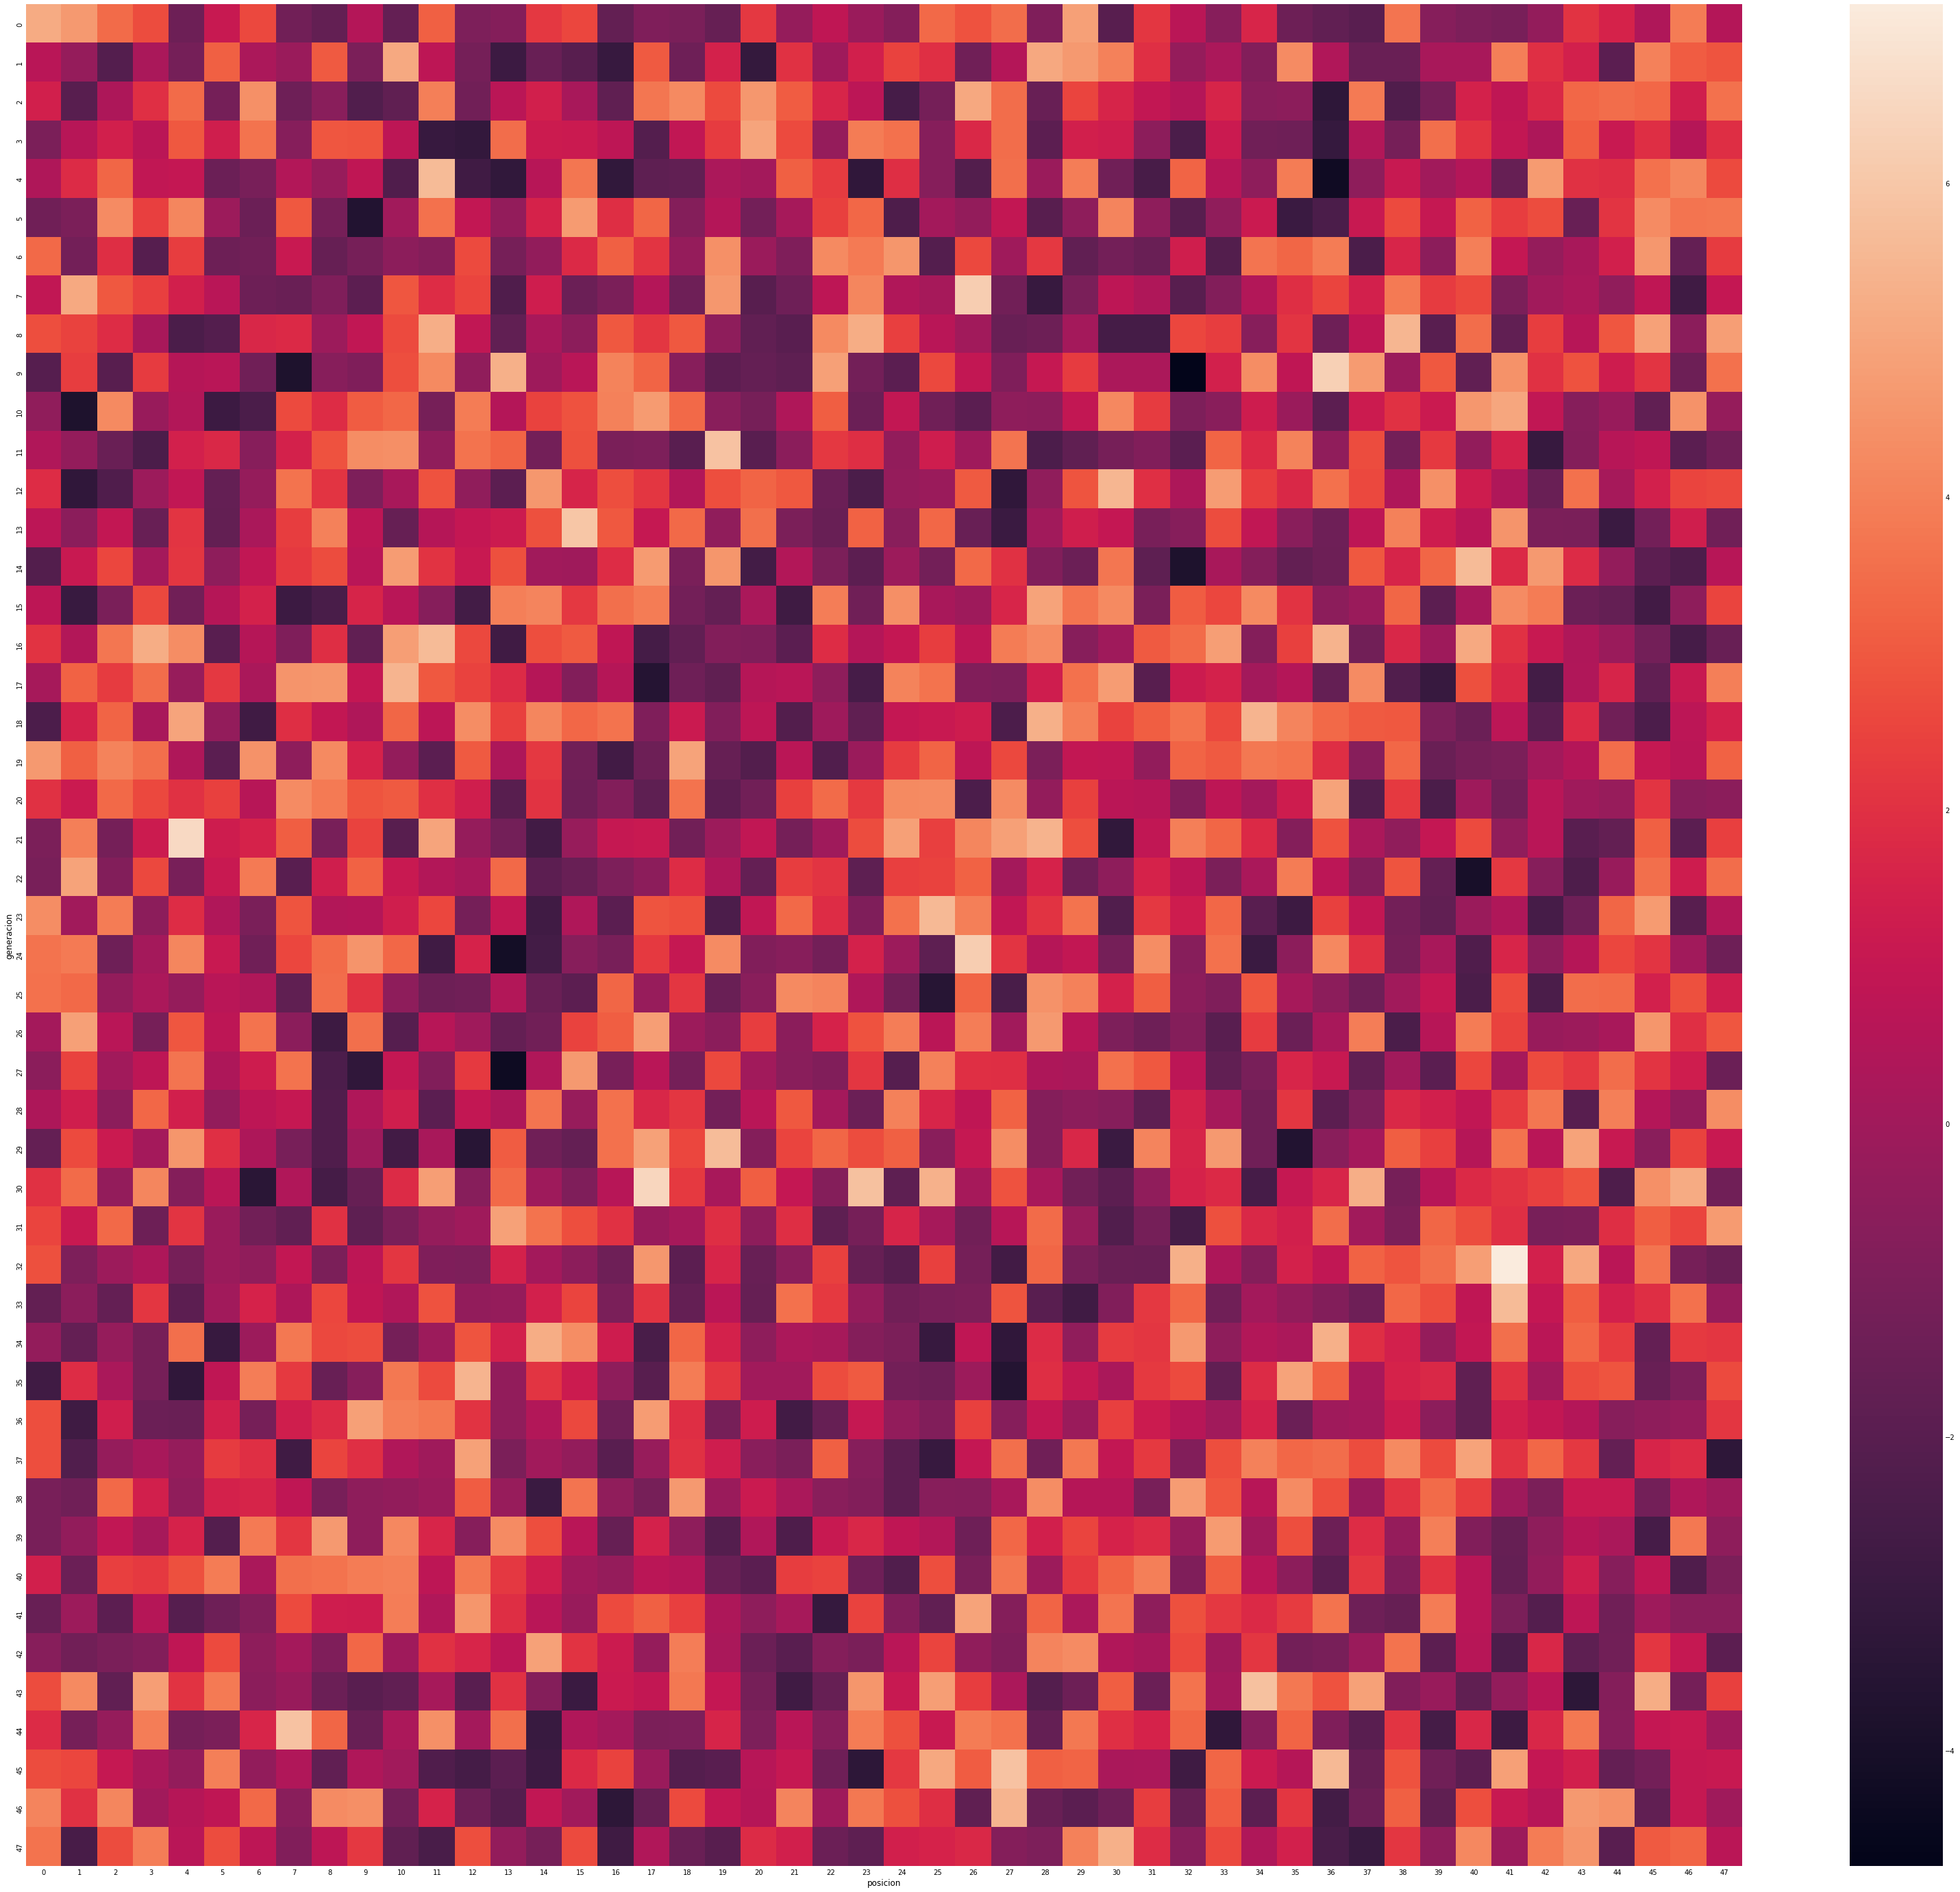

In [ ]:
array = []

for x in range(48):
  array.append(results['Solut'][len(results['Solut']) - (48 - x)])

heatmap_generations(array)